## Heat equation with oscillating bcs (surface temperature)

This notebook solves the one (or two) dimensional heat diffusion problem
 
 
 $$ \frac{\partial u}{\partial t} =
        {\alpha} \frac{\partial^2 u}{\partial x^2},
        \quad   x\in (0,L),\ t\in (0, T],$$
        
        
 $$u(x,0) = U_0,
        \quad  x\in [0,L]$$
        
        
$$  u(0, t)  = U_0 + A\cos(\omega_1 t) + B\cos(\omega_2 t),
        \quad   t\in (0, T]$$
        
        
 $$ \frac{\partial}{\partial x} u(L, t)  = 0,
        \quad  t\in (0, T]$$
        
   
 $${\alpha} = k/(\rho c)$$
 
 The one dimensional problem has the analytic solution: 
 
 $$u(x,t) = U_0 + Ae^{-b_1x}\cos (b_1 x - \omega_1 t) + Ae^{-b_2x}\cos (b_2x - \omega_2 t),\quad b_1=\sqrt{\frac{\omega_1}{2{\alpha}}}, ...$$
 
        

## FE solution

First we discretize the time derivative by a finite difference approximation, which yields a sequence of stationary problems, and then turn each stationary problem into a variational (finite element) formulation.

Let superscript $n$ denote a quantity at time $t_n$, where $n$ is an integer counting time levels. For example, $u^n$ means $u$ at time level $n$. A finite difference discretization in time first consists of sampling the PDE at some time level, say $t_{n+1}$:



\begin{equation}
\left({\partial u \over\partial t}\right)^{n+1} = \alpha \nabla^2 u^{n+1} + f^{n+1}
\end{equation}


The time-derivative can be approximated by a difference quotient.
For simplicity and stability reasons, we choose a
simple backward difference:


\begin{equation}
{{u^{n+1} - u^n}\over{\Delta t}} = \alpha \nabla^2 u^{n+1} + f^{n+1}
\end{equation}

where $\Delta t$ is the time discretization parameter.

\begin{align}
u^{n+1} - \alpha {\Delta t}\nabla^2 u^{n+1} &=  u^n + {\Delta t} f^{n+1},\quad n=0,1,2,\ldots
\end{align}

We use a finite element method to solve this equations.  This requires turning the equations into weak forms.  As usual, we multiply by a test function $v\in \hat V$ and integrate second-derivatives by parts. Introducing the symbol $u$ for $u^{n+1}$ (which is natural in the program), the resulting weak form arising from formulation


\begin{align}
a(u,v) &= \int_\Omega\left(uv + \alpha {\Delta t}
\nabla u\cdot \nabla v\right) dx\\
L_{n+1}(v) &= \int_\Omega \left(u^n + {\Delta t}  f^{n+1}\right)v dx\
\end{align}


Note that the matrix __a__ only needs to be computed once, as it consists only of the test and trial functions, their derivatives, and $\Delta t$ which we keep constant.

## Imports

In [339]:
%pylab inline
import matplotlib.pyplot as pyplt

from dolfin import *
import sys, numpy, time



Populating the interactive namespace from numpy and matplotlib


## Physical paramters

This model is solved in dimensional (SI) units

In [340]:
# Physical parameters
D = 20.   #depth in m
T_0 = 15.   #average temp
T_D = 0.0  #amplitude of daily signal
T_A = 10.0  #amplitude of annual signal

tD = 60.*60*24    #period of daily signal
tA = 365*60.*60*24 #period of daily signal

wD = 2*math.pi/tD #angular frequency of signal - radians per second
wA = 2*math.pi/tA


#http://web.archive.org/web/20150215053624/http://apollo.lsc.vsc.edu/classes/met455/notes/section6/2.html
# soil:
rho = 1.6*1e3 #kg.m-3
k0 = 0.25*1e-6 #m2.s-1 
k1 = 0.25*1e-3 #To match the analytic solution, this needs to be equal to k0


# Create mesh and define function space

In [341]:

degree = 2
aspectRatio=1.
W = D*aspectRatio
divisions = [64,64] #also use to to set dimensionality - 1D, or 2D
d = len(divisions)


d = len(divisions)  # no of space dimensions

if d == 1:
    mesh = IntervalMesh(divisions[0], 0, D)
    
elif d == 2:
    mesh = RectangleMesh(Point(-W/2, D), Point(W/2, 0), divisions[0], divisions[1])
    
    #RectangleMesh(Point(-2, 0), Point(2.0, 1.0), md.res*4, md.res, "crossed")

#The type of element here is the standard Lagrange family of elements,
V = FunctionSpace(mesh, 'Lagrange', degree)

# boundary temp condition

In [342]:
#Our boundary temp condition is defined using an expression

T_S = Expression('T_0 + T_D*cos(wD*t) + T_A*cos(wA*t)',
                 T_0=T_0, T_D=T_D, T_A=T_A, wD=wA, wA=wA, t=0.0, degree=1)





#We also use and expression to define the analytic solution


b1 = np.sqrt(wD/(2.*k0))
b2 = np.sqrt(wA/(2.*k0))

#1-D case
if d == 1:
    T_e = Expression('T_0 + T_D*exp(-1*b1*x[0])*cos(b1*x[0] - wD*t) + T_A*exp(-1*b2*x[0])*cos(b2*x[0] -wA*t)',
                 T_0=T_0, T_D=T_D, T_A=T_A, wD=wD, wA=wA, t=0.0, degree=1, b1=b1, b2=b2)

#2-D case
else:
    T_e = Expression('T_0 + T_D*exp(-1*b1*x[1])*cos(b1*x[1] - wD*t) + T_A*exp(-1*b2*x[1])*cos(b2*x[1] -wA*t)',
                 T_0=T_0, T_D=T_D, T_A=T_A, wD=wD, wA=wA, t=0.0, degree=1, b1=b1, b2=b2)

In [343]:
#Now we actuall crate the Boundary condition object

def surface(x, on_boundary):
    return on_boundary and abs(x[d-1]) < 1E-14

bc = DirichletBC(V, T_S, surface)

#all other boundary conditions are zero flux (Neummann) and we can set these implicity by ignoring them.

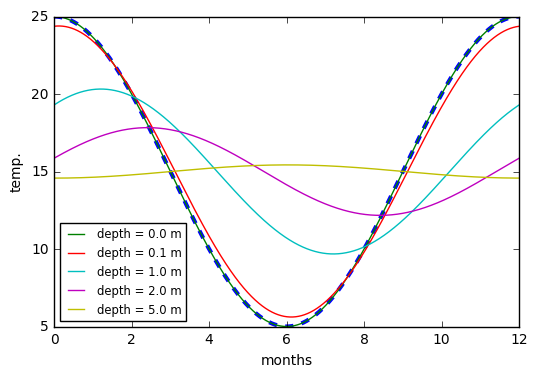

In [344]:
#plot exact solution at various depths, throughout year

times = np.linspace(0, tA, 365.*20.)
BTemps = T_0 + T_D*np.cos(wD*times ) + T_A*np.cos(wA*times )


fig, ax = pyplt.subplots()

ax.plot(12.*times/tA, BTemps, ls='--', lw=3.)
for depth in [0.0, 0.1, 1.0,2.0, 5.0]:
    eTemps = T_0 + T_D*np.exp(-1.*b1*depth)*np.cos(b1*depth - wD*times) \
    + T_A*np.exp(-1.*b2*depth)*np.cos(b2*depth -wA*times)

    ax.plot(12.*times/tA, eTemps, label = 'depth = ' + str(depth) + ' m')
    
ax.legend(loc=3, fontsize = 'small')
ax.set_xlabel('months')
ax.set_ylabel('temp.')

## Create different materials

In [345]:
#Once again we use an expression to create different materials in our domain. 
#Creating our material (in this case Kappa) as a class allows us to treat it in the Pyth Object oriented way - 
#We can alter it's attributes later, for instance

class Kappa(Expression):
    def eval(self, value, x):
        """x: spatial point, value[0]: function value."""
        d = len(x)  # no of space dimensions
        material = 0  # 0: outside, 1: inside
        if d == 1:
            if D/8. <= x[d-1] <=  2*D/8.:
                material = 1
        elif d == 2:
            if D/8. < x[d-1] < 2*D/8. and \
               -W/4. < x[0] < W/4.:
                material = 1
        value[0] = k0 if material == 0 else k1

In [346]:
D

20.0

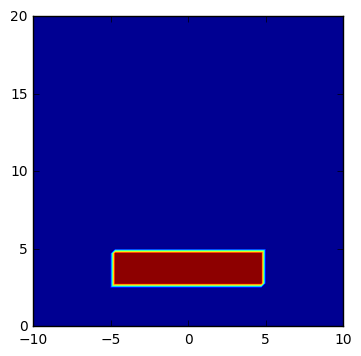

In [347]:
kappa = Kappa(degree=1)


#We can't plot an Expression directly using the Fenics plot() command, 
#But we can creat a fucntion and interpolate ourt Expression to that function


f = Function(V)
f.interpolate(kappa )
if d > 1:
    plot(f )
    
else:
    pyplt.plot(f.vector().array(), ls='', marker='o')

## Set up the FE problem

In [348]:
# We'll use u for the unknown T at the new time level and u_1 for T at the previous time level. 
u_1 = interpolate(T_e, V)

t_stop = 1*wA  #Stop at this time
dt = tA/50.  # define the time step

#Set up the trial and test functions in a the space V
u = TrialFunction(V)
v = TestFunction(V)


f = Constant(0.)     #Source term

#these two lines specify the PDE to be solved.
a = u*v*dx + kappa*dt*inner(nabla_grad(u), nabla_grad(v))*dx 
L = (u_1 + dt*f)*v*dx

# assemble 'a' only once, before the time stepping
A = assemble(a)   



In [349]:
u = Function(V)   # the unknown at a new time level
t = dt


#Note that we first defined the variable u as a TrialFunction and used it to represent the unknown in the form a. 
#Thereafter, we redefined u to be a Function object representing the solution; 
#i.e., the computed finite element function u. 

## Points to extract solution

* for 2D

In [350]:
tol = 0.001  # avoid hitting points outside the domain
x = np.linspace(-D/2. + tol, D/2. - tol, 101)
xpoints = [( x_, D/2.) for x_ in x]  # 2D points

y = np.linspace(0. + tol, D - tol, 101)
ypoints = [( 0., y_) for y_ in y]  # 2D points


In [351]:
times = []
uh = []
uv = []
uEh = []
uEv = []

## Main loop

In [352]:
maxSteps = 50
for i in range(maxSteps):
    b = assemble(L)
    T_S.t = t        #update boundary term
    T_e.t = t        #update exact solution
    bc.apply(A, b)
    solve(A, u.vector(), b)
    
    
    times.append(t)
    

    t += dt
    u_1.assign(u)
    
    
    uh.append(u_1.vector().array())
    
    u_e = interpolate(T_e, V)
    uEh.append(u_e.vector().array())
    
    #
    #uh.append(np.array([u_1(point) for point in xpoints]))
    #uv.append(np.array([u_1(point) for point in ypoints]))
    
    #uEh.append(np.array([u_e(point) for point in xpoints]))
    #uEv.append(np.array([u_e(point) for point in ypoints]))

In [353]:
if d == 1:
    for i in range(len(times)):
        pyplot.plot(uh[i], c='k')
        pyplot.plot(uEh[i], c='b', ls='--')
    


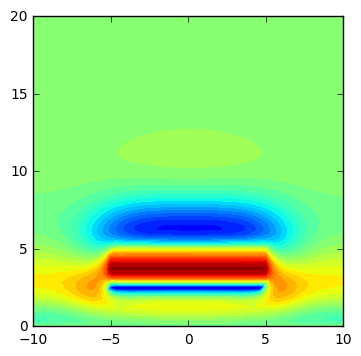

In [354]:
plot(u -u_e)

In [355]:
u_e = interpolate(T_e, V)
maxdiff = numpy.abs(u_e.vector().array()-u_1.vector().array()).max()
print 'Max error, t=%.2f: %-10.3f' % (t, maxdiff)

Max error, t=32166720.00: 0.332     


In [294]:
#f = Function(V)
#f.interpolate(T_e )

#plot(f)

## Notes

* The depth of the domain is important here because we are actually trying to mimic a Dirichlet condition at infinite distance.

